# 用户消费行为的分析**报告**
<br>数据来源于网上，是用户在一家国外网站上的消费记录

In [1]:
import pandas as pd
import numpy as np
#引入作图模块
import matplotlib.pyplot as plt
#可视化显示在页面
%matplotlib inline

In [2]:
columns = ['user_id','order_date','order_products','order_amount']
df = pd.read_csv('CDNOW_master.txt',names=columns,sep='\s+')

- user_id:用户ID
- order_date:购买日期
- order_products:购买产品数
- order_amount:购买金额

In [3]:
df['order_date'] = pd.to_datetime(df.order_date,format='%Y%m%d')
df['month'] = df.order_date.values.astype('datetime64[M]')

In [4]:
df.head()

,user_id,order_date,order_products,order_amount,month
0,1,1997-01-01,1,11.77,1997-01-01
1,2,1997-01-12,1,12.00,1997-01-01
2,2,1997-01-12,5,77.00,1997-01-01
3,3,1997-01-02,2,20.76,1997-01-01
4,3,1997-03-30,2,20.76,1997-03-01


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 5 columns):
user_id           69659 non-null int64
order_date        69659 non-null datetime64[ns]
order_products    69659 non-null int64
order_amount      69659 non-null float64
month             69659 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2)
memory usage: 2.7 MB


In [6]:
df.describe()

,user_id,order_products,order_amount
count,69659.000000,69659.000000,69659.000000
mean,11470.854592,2.410040,35.893648
std,6819.904848,2.333924,36.281942
min,1.000000,1.000000,0.000000
25%,5506.000000,1.000000,14.490000
50%,11410.000000,2.000000,25.980000
75%,17273.000000,3.000000,43.700000
max,23570.000000,99.000000,1286.010000


- 大部分订单只消费了少量商品（平均2.4），有一定的极值干扰，如：99
- 用户的消费金额，平均约为35.8元，中位数为25.98元，消费情况趋向左偏，也有一定的极值干扰，如：1286元

## 1.进行用户消费趋势的分析（按月）
- 每月的消费总金额
- 每月的消费次数
- 每月的产品购买量
- 每月的消费人数

In [7]:
group_month = df.groupby('month')

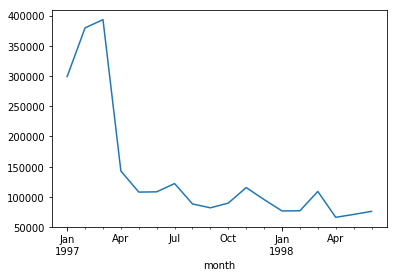

In [8]:
group_month.order_amount.sum().plot()

每月消费总金额在**前三个月**处于极高水平，均在**30万**以上，之后趋于平稳，保持在**10万**波动

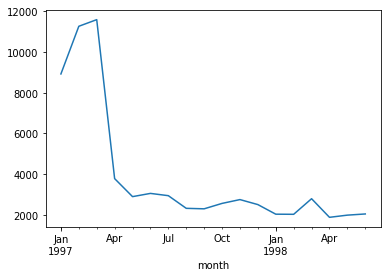

In [9]:
group_month.order_products.count().plot()

每月的消费次数也同样保持这样的趋势，前三个月都在**10000笔**左右，之后稳定在**2500笔**左右

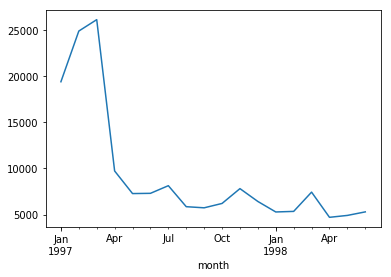

In [10]:
group_month.order_products.sum().plot()

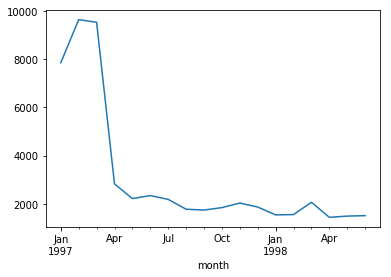

In [11]:
group_month.user_id.apply(lambda x:len(x.drop_duplicates())).plot()

去重之后，和之前的趋势差不多，前三个月消费的人数**（不含多次消费）**处于高值，之后趋于稳定，维持在**2000**左右

完整的每月**消费总金额、消费次数、产品购买量**的统计如下：

In [12]:
df.pivot_table(
    index = 'month',
    values = ['order_amount','order_products','user_id'],
    aggfunc = {
        'order_amount':'sum',
        'user_id':'count',
        'order_products':'sum'
    }
).head()

,order_amount,order_products,user_id
month,,,
1997-01-01,299060.17,19416,8928
1997-02-01,379590.03,24921,11272
1997-03-01,393155.27,26159,11598
1997-04-01,142824.49,9729,3781
1997-05-01,107933.30,7275,2895


- 每月用户平均消费金额的趋势
- 每月用户平均消费次数的趋势

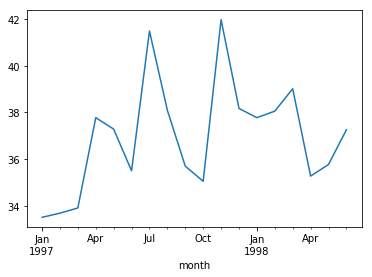

In [13]:
per_amount = group_month.order_amount.sum()/group_month.user_id.count()
per_amount.plot()

**平均消费金额=消费总金额/消费次数**，从趋势看处于波动状态，总体而言围绕在**34~42**之间，和之前统计的**均值35**匹配

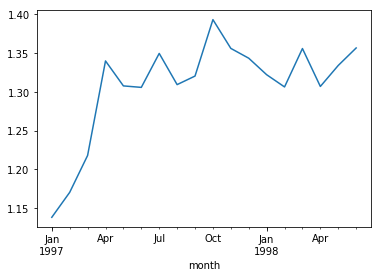

In [14]:
per_time = group_month.user_id.count()/group_month.user_id.apply(lambda x:len(x.drop_duplicates()))
per_time.plot()

**平均消费次数=消费次数/消费人数**，从趋势看，在经过前期的上扬阶段后趋于稳定，在**1.3~1.4**波动

# 2.用户个体消费分析  
- 用户消费金额，消费次数的描述统计
- 用户消费金额和消费次数的散点图
- 用户消费金额的分布图
- 用户购买产品数的分布图
- 用户累计消费金额占比（百分之多少的用户占了百分之多少的消费额）

In [15]:
group_user = df.groupby('user_id').sum()
group_user.describe()

,order_products,order_amount
count,23570.000000,23570.000000
mean,7.122656,106.080426
std,16.983531,240.925195
min,1.000000,0.000000
25%,1.000000,19.970000
50%,3.000000,43.395000
75%,7.000000,106.475000
max,1033.000000,13990.930000


由统计结果可知，用户购买产品的数量**均值约为7，标准差17**  
根据**切比雪夫定理：所有数据中，至少有24/25（或96%)的数据位于平均数5个标准差范围内**  
因此，可计算出绝大多数的用户，购买产品的数量在**[7-17 * 5,7+17 * 5]**范围内，即**92**以内   
同理，消费金额划定在**1300**以内

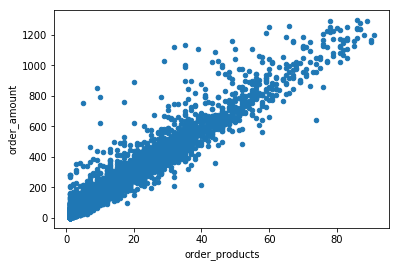

In [16]:
group_user_95 = group_user.query('(order_products < 92) & (order_amount < 1300)')
group_user_95.plot.scatter(x='order_products',y='order_amount')

对于产品来讲，购买数量越多，消费金额越高  
从散点图来看，对于95%的数据，总体呈线性分布，可以看出该网站的产品**售价基本统一**，**少部分**产品的售价脱离线性关系，可能较高，也可能较低

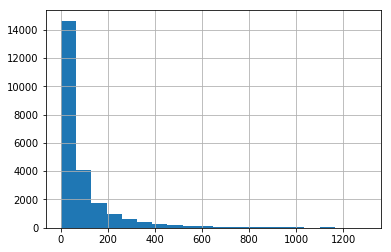

In [17]:
group_user.query('order_amount < 1300').order_amount.hist(bins=20)

由消费金额直方图可知，绝大多数的用户，消费金额在**200元**以下

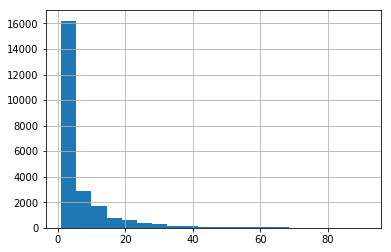

In [18]:
group_user.query('order_products < 92').order_products.hist(bins=20)

同样，对于绝大多数用户，购买的产品数量也基本在**20**以下

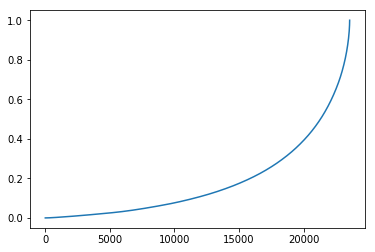

In [19]:
#累加值/总值 = 累计消费金额占比
user_cumsum = group_user.sort_values('order_amount').apply(lambda x:x.cumsum()/x.sum())
#对groupby后的表重置索引，形成新表，然后作图
user_cumsum.reset_index().order_amount.plot()

根据消费金额升序形成的累计消费金额图，横轴代表**人数**，纵轴代表消费**占比**    
在之前的统计中，一共有**23570**个用户，那么由图可知,消费金额靠后的**80%（23570 * 0.8）**的人，大约只贡献了**30%**不到的消费金额，而消费金额靠前的**20%（23570 * 0.2）**的人，贡献了超过**70%**的消费金额，大体符合**28法则**

# 3.用户消费行为  
- 用户第一次消费（首购）
- 用户最后一次消费
- 新老客消费比
  - 多少用户仅消费一次？
  - 每月新客占比？
- 用户分层
  - RFM
  - 新、活跃、回流、流失/不活跃
- 用户购买周期（按订单）
  - 用户消费周期描述
  - 用户消费周期分布
- 用户生命周期（按第一次&最后一次消费）
  - 用户生命周期描述
  - 用户生命周期分布

In [20]:
min_max = df.groupby(['user_id']).order_date.min().reset_index()
min_max.columns = ['user_id','min_date']
min_max['max_date'] = df.groupby(['user_id']).order_date.max().reset_index().order_date
min_max.head(10)

,user_id,min_date,max_date
0,1,1997-01-01,1997-01-01
1,2,1997-01-12,1997-01-12
2,3,1997-01-02,1998-05-28
3,4,1997-01-01,1997-12-12
4,5,1997-01-01,1998-01-03
5,6,1997-01-01,1997-01-01
6,7,1997-01-01,1998-03-22
7,8,1997-01-01,1998-03-29
8,9,1997-01-01,1998-06-08
9,10,1997-01-21,1997-01-21


用户的第一次购买与最后一次购买的日期如上图所示

In [21]:
(min_max['min_date'] == min_max['max_date']).value_counts()

True     12054
False    11516
dtype: int64

有**12054**位客户只消费了一次，超过一半的数量

**RFM**模型：一种商业分析的常用模型，主要有三个要素指标  
  - 最近一次消费(**R**ecency)
  - 消费频率(**F**requency)
  - 消费金额(**M**onetary)

In [22]:
rfm = df.pivot_table(
            index = 'user_id',
            values = ['order_date','order_products','order_amount'],
            aggfunc = {
                'order_date':'max',
                'order_products':'count',
                'order_amount':'sum'
            }
        )
#np.timedelta64(1,'D')表示日期单位，是以'天'为单位，运算后可把日期值转换为数值
rfm['R'] = (rfm.order_date.max() - rfm.order_date) / np.timedelta64(1,'D')
rfm.rename(columns={'order_products':'F','order_amount':'M'},inplace=True)
rfm.head()

,M,order_date,F,R
user_id,,,,
1,11.77,1997-01-01,1,545.0
2,89.00,1997-01-12,2,534.0
3,156.46,1998-05-28,6,33.0
4,100.50,1997-12-12,4,200.0
5,385.61,1998-01-03,11,178.0


在本次分析报告中，对于最后一次消费，可转换为与当前日期**（产品的最后一次购买日期）**相隔的日期来分析，并以三个指标的各个**均值**进行区域划分，可划分出**8**个区域:
  - 1表示高于均值，0表示低于均值
  - 111:最后一次消费已经比较久远，但消费频率高，消费金额也高，是重要的**价值**用户
  - 011:最近有消费，且消费频率高，消费金额也高，是重要的**保持**用户
  - 101:最后一次消费已经比较久远，消费频率也较低，但消费金额高，是重要的**挽留**用户
  - 001:最近有消费，消费金额也高，但消费频率较低，可能是新客，是重要的**发展**用户
  - ......

In [23]:
def rfm_func(x):
    level = x.apply(lambda x:'1' if x>=0 else '0')  #注：此处是字符'0'和字符'1'
    label = level.R + level.F +level.M
    d = {
        '111':'重要价值用户',
        '011':'重要保持用户',
        '101':'重要挽留用户',
        '001':'重要发展用户',
        '110':'一般价值用户',
        '010':'一般保持用户',
        '100':'一般挽留用户',
        '000':'一般发展用户'
    }
    result = d[label]
    return result
rfm['label'] = rfm[['R','F','M']].apply(lambda x:x - x.mean()).apply(rfm_func,axis = 1)
rfm.head()

,M,order_date,F,R,label
user_id,,,,,
1,11.77,1997-01-01,1,545.0,一般挽留用户
2,89.00,1997-01-12,2,534.0,一般挽留用户
3,156.46,1998-05-28,6,33.0,重要保持用户
4,100.50,1997-12-12,4,200.0,一般保持用户
5,385.61,1998-01-03,11,178.0,重要保持用户


In [24]:
rfm.groupby('label').agg(['sum','count'])

M             F                 R       
               sum  count    sum  count        sum  count
label                                                    
一般价值用户    36200.21    543   1782    543   237754.0    543
一般保持用户   141127.20   1974   7371   1974   309037.0   1974
一般发展用户    75781.48   1532   3064   1532   311519.0   1532
一般挽留用户   409272.88  13608  15589  13608  6750356.0  13608
重要价值用户   103260.14    449   1950    449   194091.0    449
重要保持用户  1591666.47   4617  38490   4617   517048.0   4617
重要发展用户    46158.16    268    536    268    56855.0    268
重要挽留用户    96849.09    579    877    579   278754.0    579

'sum'列看金额，可知，**重要保持用户**在金额占比中最大  
'count'列看人数，可知，**一般挽留用户**人数最多  
综合分析，**重要保持用户**是本产品的消费主力，而**重要价值用户、重要发展用户、重要挽留用户**人数虽少，但消费金额较大，这几个群体都值得重点关注

In [25]:
group_permonth = df.pivot_table(
                    index = 'user_id',
                    columns = 'month',
                    values = 'order_date',
                    aggfunc = 'count'
                ).fillna(0)
df_permonth = group_permonth.applymap(lambda x:1 if x > 0 else 0)
df_permonth.head()

month,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,1998-04-01 00:00:00,1998-05-01 00:00:00,1998-06-01 00:00:00
user_id,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
5,1,1,0,1,1,1,1,0,1,0,0,1,1,0,0,0,0,0


按月统计每个用户的消费次数，有消费计为1，反之为0，另外，可知该份消费数据一共有**18**个月的记录

In [26]:
def func_status(x):
    status = []
    for i in range(18):
        #若本月没有消费
        if x[i] == 0:
            if len(status) > 0:
                if status[i-1] == 'unreg':
                    status.append('unreg')
                else:
                    status.append('unactive')
            else:
                status.append('unreg')
        #若本月有消费
        else:
            if len(status) > 0:
                if status[i-1] == 'unreg':
                    status.append('new')
                elif status[i-1] == 'unactive':
                    status.append('return')
                else:
                    status.append('active')
            else:
                status.append('new')
    return status

针对每个用户18个月的消费情况，设定他们每个月的消费状态
- 若该月未消费
  - 若之前是未注册(unreg)，则依旧为未注册
  - 若之前有消费，则为流失/不活跃(unactive)
  - 若为首月，则为未注册
- 若该月有消费
  - 若之前未注册，则为新用户
  - 若之前为流失/不活跃，则为回流(return)
  - 若上月有消费，则为活跃(active)
  - 若为首月，则为新用户

In [27]:
df_status = df_permonth.apply(func_status,axis=1,result_type='expand')
df_status.columns = list(df_permonth.columns)
df_status.head()

,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,1998-04-01 00:00:00,1998-05-01 00:00:00,1998-06-01 00:00:00
user_id,,,,,,,,,,,,,,,,,,
1,new,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive
2,new,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive
3,new,unactive,return,active,unactive,unactive,unactive,unactive,unactive,unactive,return,unactive,unactive,unactive,unactive,unactive,return,unactive
4,new,unactive,unactive,unactive,unactive,unactive,unactive,return,unactive,unactive,unactive,return,unactive,unactive,unactive,unactive,unactive,unactive
5,new,active,unactive,return,active,active,active,unactive,return,unactive,unactive,return,active,unactive,unactive,unactive,unactive,unactive


In [28]:
df_status_ct = df_status.replace('unreg',np.NAN).apply(lambda x:pd.value_counts(x))
df_status_ct = df_status_ct.fillna(0).T
df_status_ct

,active,new,return,unactive
1997-01-01,0.0,7846.0,0.0,0.0
1997-02-01,1157.0,8476.0,0.0,6689.0
1997-03-01,1681.0,7248.0,595.0,14046.0
1997-04-01,1773.0,0.0,1049.0,20748.0
1997-05-01,852.0,0.0,1362.0,21356.0
1997-06-01,747.0,0.0,1592.0,21231.0
1997-07-01,746.0,0.0,1434.0,21390.0
1997-08-01,604.0,0.0,1168.0,21798.0
1997-09-01,528.0,0.0,1211.0,21831.0
1997-10-01,532.0,0.0,1307.0,21731.0


未注册状态在分析中无实际意义，因此从状态中去掉，并统计各月各状态的人次  
以前两个月为例分析：  
第一个月，所有用户均只可能为**新用户**  
第二个月，对于第一个月的这些用户，**1157**人还在消费，为**活跃**用户，**6689**人没有消费，为**流失**用户，两者相加，与第一个月的用户数量一致，结果正确

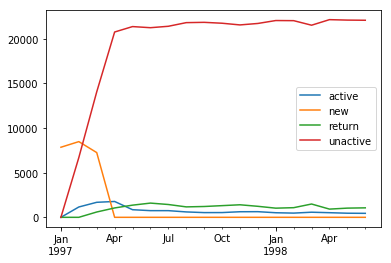

In [29]:
df_status_ct.plot()

结合图表分析：
  - 在前三个月产生新客户以后，之后就再没有任何新的用户前来消费，产品本身的吸引力很低
  - 流失用户在前期增长速度很快，之后维持在**两万**以上的用户流失，产品的质量品质是否有问题有待评估
  - 回流人数以及活跃用户均处于较低水平，且有慢速下降的趋势，表明对产品的忠诚度的用户不多，且人数还在不断的减少

In [30]:
group_date = df.groupby('user_id').apply(lambda x: x.order_date - x.order_date.shift())
group_date.head()

user_id   
1        0       NaT
2        1       NaT
         2    0 days
3        3       NaT
         4   87 days
Name: order_date, dtype: timedelta64[ns]

In [31]:
group_date.describe()

count                      46089
mean     68 days 23:22:13.567662
std      91 days 00:47:33.924168
min              0 days 00:00:00
25%             10 days 00:00:00
50%             31 days 00:00:00
75%             89 days 00:00:00
max            533 days 00:00:00
Name: order_date, dtype: object

用户平均购买间隔为**69**天，最小0天，最大533天

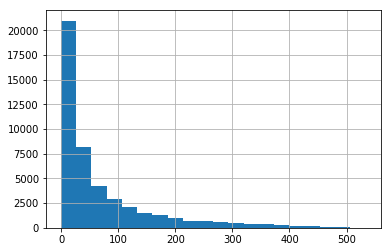

In [34]:
(group_date/np.timedelta64(1,'D')).hist(bins=20)

从图表可知，大部分的用户，购买间隔都在50天以内

In [35]:
min_max.head()

,user_id,min_date,max_date
0,1,1997-01-01,1997-01-01
1,2,1997-01-12,1997-01-12
2,3,1997-01-02,1998-05-28
3,4,1997-01-01,1997-12-12
4,5,1997-01-01,1998-01-03


In [36]:
(min_max['max_date'] - min_max['min_date']).describe()

count                       23570
mean     134 days 20:55:36.987696
std      180 days 13:46:43.039788
min               0 days 00:00:00
25%               0 days 00:00:00
50%               0 days 00:00:00
75%             294 days 00:00:00
max             544 days 00:00:00
dtype: object

用户的生命周期（第一次消费到最后一次消费），平均在**134**天  
中位数为0，表示绝大多数用户，只消费了一次

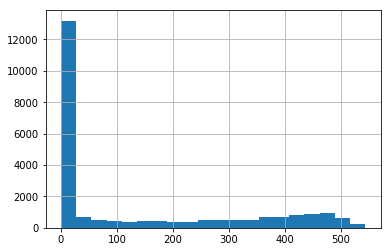

In [37]:
((min_max['max_date'] - min_max['min_date'])/np.timedelta64(1,'D')).hist(bins=20)

可以看出，本产品，绝大多数用户，在消费了一次过后，便不会再次消费，和之前的结论匹配

## 4.复购率和回购率分析
- 复购率  
  - 自然月内，购买多次的用户占比
- 回购率
  - 曾经购买过的用户在某一个时期内的再次购买的占比

In [38]:
group_permonth.head()

month,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,1998-04-01 00:00:00,1998-05-01 00:00:00,1998-06-01 00:00:00
user_id,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0


In [39]:
a = group_permonth.applymap(lambda x:1 if x > 1 else 0 if x == 1 else np.NAN)
a.head()

month,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,1998-04-01 00:00:00,1998-05-01 00:00:00,1998-06-01 00:00:00
user_id,,,,,,,,,,,,,,,,,,
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN


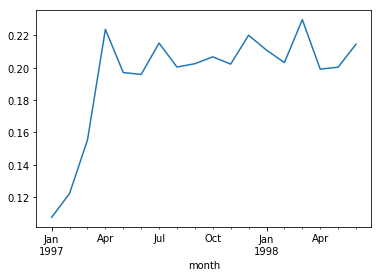

In [40]:
(a.sum()/a.count()).plot()

上图为**复购率**的趋势图，可知，复购率在经过一段时间上扬后，维持在**20%-22%**之间

In [41]:
df_permonth.head()

month,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,1998-04-01 00:00:00,1998-05-01 00:00:00,1998-06-01 00:00:00
user_id,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
5,1,1,0,1,1,1,1,0,1,0,0,1,1,0,0,0,0,0


In [42]:
def huigou(x):
    status=[]
    for i in range(17):
        #若本月有消费
        if x[i] == 1:
            if x[i+1] == 1:
                status.append(1)
            if x[i+1] == 0:
                status.append(0)
        else:
            status.append(np.NAN)
    #对最后一个月填充NAN
    status.append(np.NAN)
    return status

In [43]:
df_huigou = df_permonth.apply(huigou,axis=1,result_type='expand')
df_huigou.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
user_id,,,,,,,,,,,,,,,,,,
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,0.0,NaN,1.0,1.0,1.0,0.0,NaN,0.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN


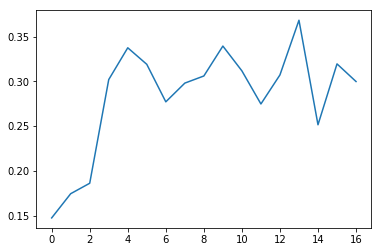

In [44]:
(df_huigou.sum()/df_huigou.count()).plot()

**回购率**的趋势图如上

In [45]:
df.head()

,user_id,order_date,order_products,order_amount,month
0,1,1997-01-01,1,11.77,1997-01-01
1,2,1997-01-12,1,12.00,1997-01-01
2,2,1997-01-12,5,77.00,1997-01-01
3,3,1997-01-02,2,20.76,1997-01-01
4,3,1997-03-30,2,20.76,1997-03-01
